In [53]:
from datasets import load_dataset

ds = load_dataset("ahmed-masry/unichart-pretrain-data", split="train")

In [4]:
import re
IMAGE_PTTN = "<image.?.?.?.?>"
def replace_image_tokens(input_string, start_count=1):
    count = start_count
    while re.search(IMAGE_PTTN, input_string):
        input_string = re.sub(IMAGE_PTTN, f"<|image_{count}|>", input_string, count=1)
        count += 1
    return input_string, count

In [5]:
def deduplicate_dicts(dict_list):
    # Convert each dictionary to a frozenset of items to make it hashable
    seen = set()
    unique_dicts = []
    for d in dict_list:
        # Convert dictionary to a tuple of sorted items to ensure hashability
        t = tuple(sorted(d.items()))
        if t not in seen:
            seen.add(t)
            unique_dicts.append(d)
    return unique_dicts


In [6]:
import base64
from PIL import Image
from io import BytesIO

base64_image_string = ds[0]["image"]

image_data = base64.b64decode(base64_image_string)

# Create an Image object
image = Image.open(BytesIO(base64_image_string))

In [54]:
ds[0]

{'imgname': 'neural_caption_51.png',
 'query': '<opencqa> What does fppi stand for?',
 'label': 'the following graph describes how the fppi (farm product price index) about production of eggs in shell in canada has been slowly increasing during 2017. in particular, it increased from 1362 in february to 1371 in december. a line chart about the global growth and punctual drops of the monthly egg production in canada, 2017. this graph depicts the production of eggs in shell in canada during 2017. the unit is farm product price index (fppi). production starts off at approximately 1363 in january and goes down to the lowest production at 1362 during february. during the months of march and may the production remains unchanged at 1365. there is a slight increase of production during june, until it remain stable throughout july until september at 1367. then, a small drop can be observed, which is followed by a sharp increase, until it peaks during december at 1371.'}

In [55]:
from tqdm import tqdm 
import os
import re 

data = {
    "image_folder": "/home/t-sijoshi/content/UniChart/Images",
    "len_samples": 0,
}

data["samples"] = []

for i, item in tqdm(enumerate(ds), total=len(ds)):
    query = item["query"]
    
    answer = str(item["label"])

    data["samples"].append(
        {
            "id": i,
            "image_1": item["imgname"],
            "conversations":
            [
                {
                    "from": "user", 
                    "value": re.sub("<opencqa>", "<image>", query)
                },
                {
                    "from": "assistant",
                    "value": answer
                }
            ]
        }
    )
data["len_samples"] = len(data["samples"])

100%|██████████| 6898333/6898333 [02:51<00:00, 40309.34it/s]


In [59]:
import json 
data["len_samples"] = len(data["samples"])
with open("/home/t-sijoshi/multimodal-data-gen/downloaded_datasets/chartqa-train/unichart_data.json", "w") as f:
    json.dump(data, f, indent=3)

In [46]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/skill_desc/chartqa_human.json", "r") as f:
    skill_desc = json.load(f)    

In [49]:
count = 0
for skill_id in skill_desc["skills"].keys():
    new_idx = []
    for i in skill_desc["skills"][skill_id]["sample_idx"]:
        skill_desc["samples"].append(data["samples"][i])
        new_idx.append(count)
        count += 1
    skill_desc["skills"][skill_id]["sample_idx"] = new_idx

In [50]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/skill_desc/chartqa_human.json", "w") as f:
    json.dump(skill_desc, f, indent=3)    

In [56]:
skill_sample_map = {}
for field in fields:
    sample_idx = 0
    for item in ds:
        skill = " ".join(item["metadata"]["skills"])
        
        if skill not in skill_sample_map:
            skill_sample_map[skill] = []
        skill_sample_map[skill].append(sample_idx)
        sample_idx += 1

In [57]:
skill_count_map = {}
for key in skill_sample_map.keys():
    skill_count_map[key] = len(skill_sample_map[key])

In [58]:
import matplotlib.pyplot as plt

def plot_pie_chart(data, title='Pie Chart'):
    """
    Creates a pie chart from a dictionary where keys are categories and values are integers,
    with a legend placed outside the plot, sorted by size (largest to smallest),
    and including the fraction of data in brackets in the legend.

    Parameters:
    - data (dict): Dictionary with keys as categories and values as integers.
    - title (str): Title of the pie chart.
    """
    # Sort data by size (largest to smallest)
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    labels = sorted_data.keys()
    sizes = sorted_data.values()

    # Calculate percentages
    total = sum(sizes)
    percentages = [f"{label} ({size/total:.1%})" for label, size in sorted_data.items()]

    plt.figure(figsize=(8, 8))
    
    # Create a pie chart without labels
    wedges, _ = plt.pie(sizes, startangle=140)
    
    # Add a legend outside the plot with percentages
    plt.legend(wedges, percentages, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
    plt.title(title)
    plt.show()
    return labels, sizes


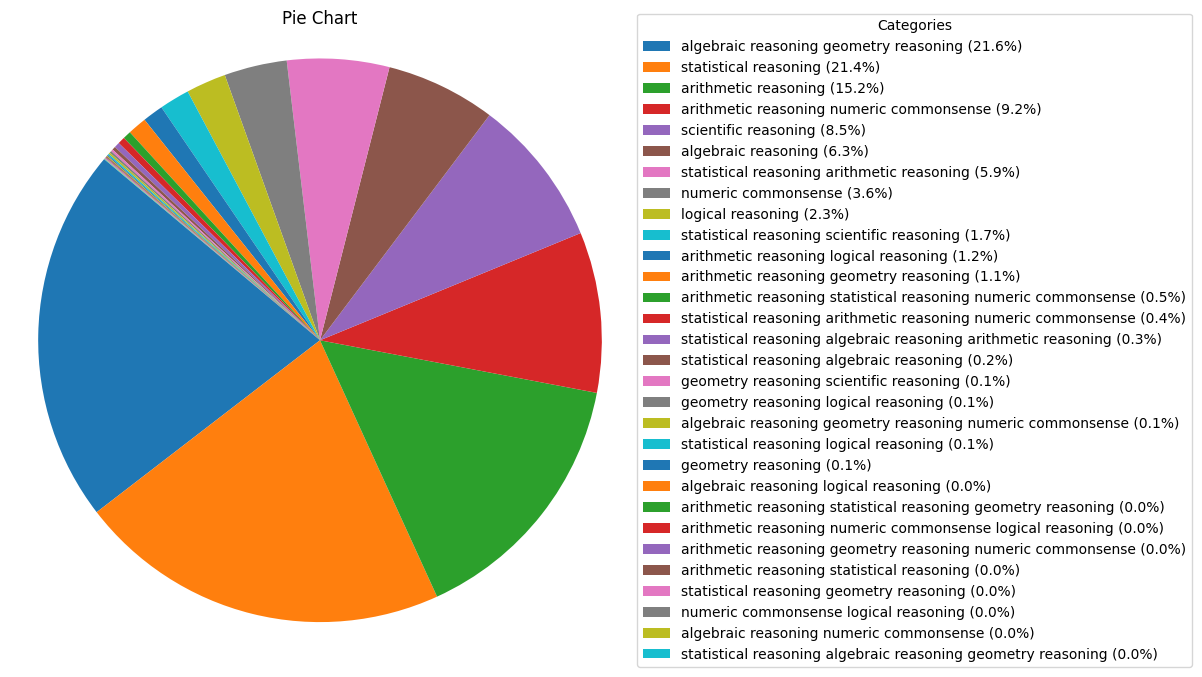

In [59]:
top_skills, counts = plot_pie_chart(skill_count_map)

In [22]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/skill_desc/mathvista_human.json", "r") as f:
    data = json.load(f)

In [28]:
ds = ds[field]

In [61]:
top_skills = list(top_skills)
visual_content_mappings = {}
for skill in top_skills[:5]:
    visual_content_mappings[skill] = {}
    for i in skill_sample_map[skill]:
        visual_content_mappings[skill][ds[i]["metadata"]["context"]] = i

In [64]:
with open("/home/t-sijoshi/multimodal-data-gen/downloaded_datasets/mathvista-test/data_gpt_answer.json", "r") as f:
    gpt = json.load(f)
    answers = {}
    for sample in gpt["samples"]:
        answers[sample["id"]] = sample["conversations"][1]["value"]

In [67]:
from tqdm import tqdm 
import ast
import os

data = {
   "image_folder": "/home/t-sijoshi/multimodal-data-gen/ref_images/mathvista_test/",
   "len_samples": 0,
   "skills": {},
   "samples": []
}

count = 0
for skill in visual_content_mappings.keys():
    for visual_context in visual_content_mappings[skill].keys():
        data["skills"][str(count)] = {
            "skill": skill, 
            "keyword": visual_context, 
            "image_type": visual_context,
            "sample_idx": [count]
        }
        item = ds[visual_content_mappings[skill][visual_context]]
        query = item["query"]
        data["samples"].append(
            {
                "id": item["pid"],
                "conversations":
                [
                    {
                        "from": "user", 
                        "value": "<image> " + re.sub("<image.?.?.?.?>", "<image>", query)
                    },
                    {
                        "from": "assistant",
                        "value": answers[item["pid"]]
                    }
                ],
                "sub_task": " ".join(item["metadata"]["skills"]),
                "question_type": item["question_type"],
                "answer_type": item["answer_type"]
            }
        )
        
        item["decoded_image"].convert("RGB").save(os.path.join(data["image_folder"], item["image"]))
        data["samples"][-1]["image_1"] = item["image"]

        count += 1
data["len_samples"] = len(data["samples"])

In [68]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/skill_desc/mathvista_top5_skills.json", "w") as f:
    json.dump(data, f, indent=3)

In [19]:
for key in data["skills"].keys():
    print(data["skills"][key]["skill"])

algebraic reasoning
algebraic reasoning
algebraic reasoning
algebraic reasoning
algebraic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
arithmetic reasoning
geometry reasoning
geometry reasoning
geometry reasoning
geometry reasoning
geometry reasoning
geometry reasoning
geometry reasoning
logical reasoning
logical reasoning
numeric commonsense
numeric commonsense
numeric commonsense
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
scientific reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning
statistical reasoning


In [23]:
data["samples"][2]

{'id': '3',
 'conversations': [{'from': 'human',
   'value': '<image> Hint: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.\nQuestion: △ABC的两内角平分线OB、OC相交于点O，若∠A＝110°，则∠BOC＝（）\nChoices:\n(A) 135°\n(B) 140°\n(C) 145°\n(D) 150°'},
  {'from': 'gpt', 'value': 'C'}],
 'sub_task': 'geometry reasoning algebraic reasoning',
 'question_type': 'multi_choice',
 'answer_type': 'text',
 'image_1': 'images/3.jpg'}

In [24]:
import json 

with open("/home/t-sijoshi/multimodal-data-gen/downloaded_datasets/mathvista-testmini/data.json", "w") as f:
    json.dump(data, f, indent=3)